In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sm
import torch
import torchvision.transforms as transforms

In [2]:
data1 = np.load('/home/aliia/Simagin/iers/train-1.npy')
data2 = np.load('/home/aliia/Simagin/iers/train-2.npy')
data3 = np.load('/home/aliia/Simagin/iers/train-3.npy')
data4 = np.load('/home/aliia/Simagin/iers/train-4.npy')
data = np.concatenate((data1, data2, data3, data4), axis=0)

/home/aliia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/home/aliia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


MemoryError: 

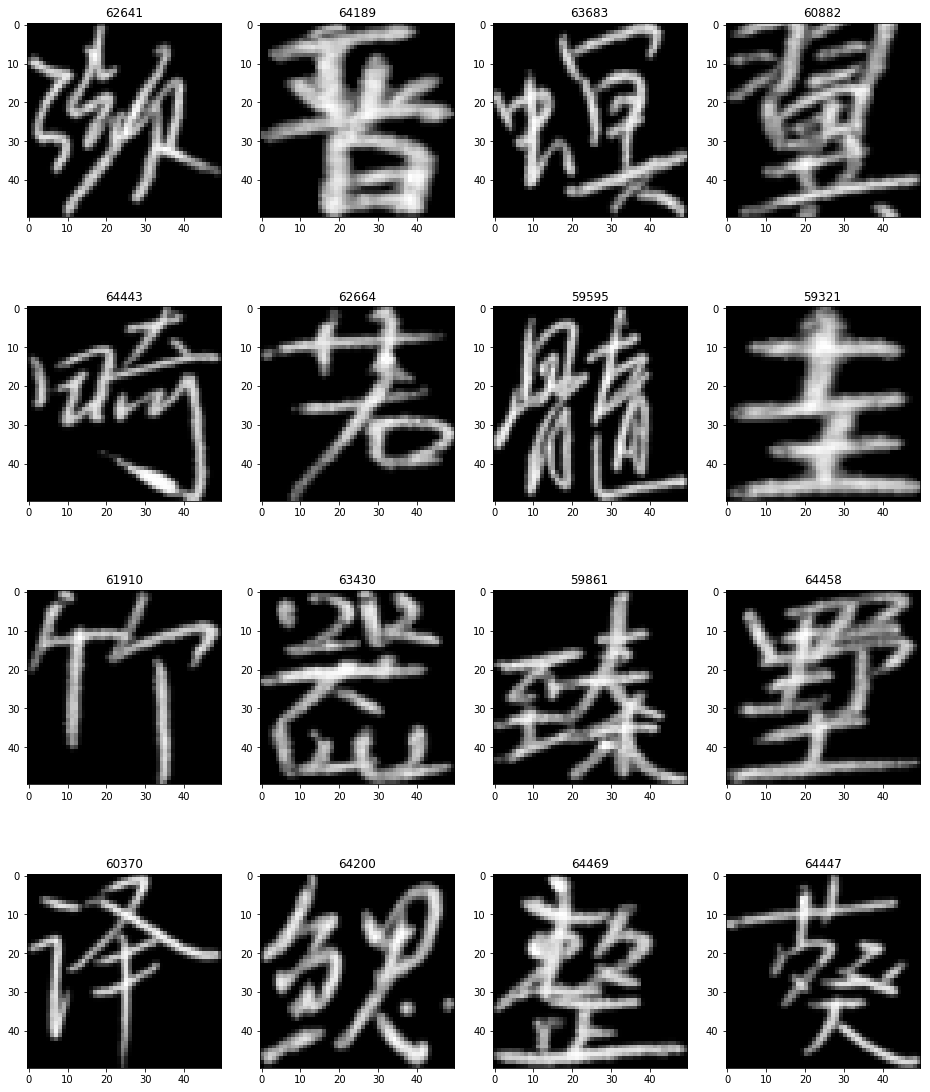

In [3]:
np.random.shuffle(data)
np.random.shuffle(data)
width, height = 4, 4
plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(data, 1):
    image = sm.imresize(image, (50, 50))
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(255 - image, cmap='gray')

all_train = np.zeros(data.shape[0] * 50 * 50)
all_train = all_train.reshape(data.shape[0], 50, 50)
all_lable = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    all_train[i] = sm.imresize(data[i][0], (50, 50))
    all_lable[i] = data[i][1]
all_train = 255 - all_train

np.save("/home/aliia/Simagin/iers/all_train.npy", all_train)
np.save("/home/aliia/Simagin/iers/labels.npy", all_lable)

In [ ]:
# all_train = np.load('/home/aliia/Simagin/iers/all_train.npy')
# labels = np.load('/home/aliia/Simagin/iers/labels.npy')
labels = all_lable
all_train = torch.from_numpy(all_train).float()
labels_uni = torch.from_numpy(labels).long()
dic = {}
cur = 0
labels = np.zeros(labels_uni.shape[0], dtype='long')
unicod = np.zeros(1000, dtype='long')
for i in range(labels_uni.shape[0]):
    if (labels_uni[i].item() not in dic):
        dic[labels_uni[i].item()] = cur
        unicod[cur] = labels_uni[i].item()
        cur += 1
    labels[i] = dic[labels_uni[i].item()]
labels = torch.from_numpy(labels)

train_data = all_train[:int(data.shape[0]/ 8 * 7)]
train_labels = labels[:int(data.shape[0]/ 8 * 7)]
test_data = all_train[int(data.shape[0]/ 8 * 7):]
test_labels = labels[int(data.shape[0]/ 8 * 7):]

all_train = torch.utils.data.TensorDataset(train_data, train_labels)
all_test = torch.utils.data.TensorDataset(test_data, test_labels)

batch_size = 10
train_loader = torch.utils.data.DataLoader(all_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(all_test, batch_size=batch_size, shuffle=True)



In [ ]:
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         #Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
#         self.relu1 = nn.ReLU()
        
#         #Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
#         #Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()
        
#         #Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         #Dropout for regularization
#         self.dropout = nn.Dropout(p=0.5)
        
#         #Fully Connected 1
#         self.fc1 = nn.Linear(4608, 1000)
        
#     def forward(self, x):
#         x = x.view(-1, 1, 50, 50)
#         #Convolution 1
#         out = self.cnn1(x)
#         out = self.relu1(out)
        
#         #Max pool 1
#         out = self.maxpool1(out)
        
#         #Convolution 2
#         out = self.cnn2(out)
#         out = self.relu2(out)
        
#         #Max pool 2
#         out = self.maxpool2(out)
        
#         #Resize
#         out = out.view(out.size(0), -1)
        
#         #Dropout
#         out = self.dropout(out)

#         #Fully connected 1
#         out = self.fc1(out)
#         return out
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc3 = nn.Linear(16 * 9 * 9, 120)
        self.fc1 = nn.Linear(120, 600)
        self.fc2 = nn.Linear(600, 1000)
        
    def forward(self, x):
        x = x.view(-1, 1, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(784, 1000) # params - 2D-Tensor 28*28x100
# #         self.fc2 = nn.Linear(200, 1000) # params - 2D-Tensor 28*28x100

#     def forward(self, x):
#         # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
#         x = x.view(-1, 28*28)
#         x = self.fc1(x)
# #         x = F.sigmoid(x)
# #         x = self.fc2(x)
#         return x

In [ ]:
model = Net()

In [ ]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
accuracy_data_train = []
accuracy_data_test = []

In [ ]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#         else:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def test():
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_correct_percent = 100. * test_correct / len(test_loader.dataset)
        print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= len(train_loader.dataset)
        train_correct_percent = 100. * train_correct / len(train_loader.dataset)
    accuracy_data_train.append(train_correct_percent)
    accuracy_data_test.append(test_correct_percent) 

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

In [ ]:
epoch_size = 10
for epoch in range(1, epoch_size):
    train(epoch)
    test()

In [ ]:
test()